In [1]:
import cv2
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## ImageAugmentation

In [2]:
class ImageAugmentation:
    def __init__(self, path = "./"):
        self.dim = (64, 36)
        self.folder_list = glob.glob(path + "/*")
        self.folders = []
        for p in self.folder_list:
            self.folders.append(p.split("\\")[-1])
            
        
        
        for folder in self.folders:
            self.files = glob.glob(path + "/" + folder + "/*")
            
            for file in self.files:
                #resize
                file_name = file.split("\\")[-1]
                img = cv2.imread(path + "/" + folder + "/" + file_name)
                resized = cv2.resize(img, self.dim,interpolation=cv2.INTER_AREA)                
                cv2.imwrite(path + "/" + folder + "/" + file_name,resized)
                
                
                constraint = ["rx_", "ry_"]
                if file_name[:3] not in constraint and path.split('/')[-1] != 'test':
                    rows, cols, dim = resized.shape
                    My = np.float32([[-1,  0, cols],
                                    [0 ,  1, 0   ],
                                    [0 ,  0, 1   ]])
                    Mx = np.float32([[1,  0, 0],
                                    [0 ,  -1, rows],
                                    [0 ,  0, 1   ]])
                    #resized img reflection on y axis
                    reflected_img = cv2.warpPerspective(resized,My,(int(cols),int(rows)))
                    cv2.imwrite(path + "/" + folder + "/" + "ry_"+ file_name,reflected_img)
                    
                    #resized img reflection on x axis
                    reflected_img = cv2.warpPerspective(resized,Mx,(int(cols),int(rows)))
                    cv2.imwrite(path + "/" + folder + "/" + "rx_"+ file_name,reflected_img)
        

In [3]:
# resize i reflect 
#ImageAugmentation("./data/train")
#ImageAugmentation("./data/test")

## Data loading

In [4]:
class CDataset(Dataset):
    def __init__(self, train = False, test = False):
        if(train):
            self.data_path = "./data/train/"
        if(test):
            self.data_path = "./data/test/"
        self.folder_list = glob.glob(self.data_path + "*")

        self.data = []
        for folder in self.folder_list:
            folder_name = folder.split("\\")[-1]
            for img_path in glob.glob(self.data_path + folder_name + "/*.jpg"):
                self.data.append([img_path, folder_name])
        self.class_map = {"Car": 0, "Truck": 1, "Bicycle": 2, "Dog": 3}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        img_path, class_name = self.data[i]
        img = cv2.imread(img_path)
        class_id = self.class_map[class_name]
        img_tensor = torch.tensor(img, dtype=torch.float)
        img_tensor = img_tensor.permute(2,0,1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [5]:
if __name__ == "__main__":
    batch_size = 5
    train_dataset = CDataset(train=True)
    data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = CDataset(test=True)
    data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    #for imgs, labels in data_loader:
        #print("Batch of images has shape: ",imgs.shape)
        #print("Batch of labels has shape: ", labels.shape)

## CNN

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.PReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.PReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.6), 
            nn.Linear(18432, 4096),
            nn.PReLU(),
            nn.Dropout(p=0.6), 
            nn.Linear(4096, 256),
            nn.PReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(256, len(train_dataset.class_map)),
        )


    def forward(self, x): 
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
    


In [9]:
net = CNN()
def calc_input_dims():
        batch_data = torch.zeros((1, 3, 64, 36))
        
        batch_data = net.conv_layer(batch_data)
        
        return int(np.prod(batch_data.size()))
calc_input_dims()

18432

In [10]:
lossF = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [11]:
net.to(device)  
epochs = 50
loss_array = []

for epoch in range(epochs): 
    print("Starting epoch #" + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(data_loader_train, 0):
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = lossF(outputs, labels.flatten())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #if i % 100 == 0 and i != 0: 
            #print('loss: %.3f' %
                  #running_loss))
            #running_loss = 0.0
    loss_array.append(float(running_loss))
    

print('Finished Training')

Starting epoch #0
Starting epoch #1
Starting epoch #2
Starting epoch #3
Starting epoch #4
Starting epoch #5
Starting epoch #6
Starting epoch #7
Starting epoch #8
Starting epoch #9
Starting epoch #10
Starting epoch #11
Starting epoch #12
Starting epoch #13
Starting epoch #14
Starting epoch #15
Starting epoch #16
Starting epoch #17
Starting epoch #18
Starting epoch #19
Starting epoch #20
Starting epoch #21
Starting epoch #22
Starting epoch #23
Starting epoch #24
Starting epoch #25
Starting epoch #26
Starting epoch #27
Starting epoch #28
Starting epoch #29
Starting epoch #30
Starting epoch #31
Starting epoch #32
Starting epoch #33
Starting epoch #34
Starting epoch #35
Starting epoch #36
Starting epoch #37
Starting epoch #38
Starting epoch #39
Starting epoch #40
Starting epoch #41
Starting epoch #42
Starting epoch #43
Starting epoch #44
Starting epoch #45
Starting epoch #46
Starting epoch #47
Starting epoch #48
Starting epoch #49
Finished Training


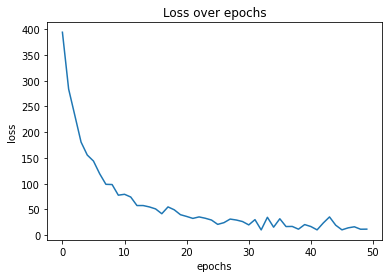

In [12]:
x = np.arange(epochs)
y = np.array(loss_array)
plt.title('Loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(x, y)
plt.show()

In [13]:
net.to(torch.device("cpu")) 

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): PReLU(num_parameters=1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=18432, out_features=4096, bias=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(

In [34]:
correct = 0
total = 0
predict = []
true = []

def find_max_elem(array):
    _max = float('-inf')
    index = 0
    for i in range(len(array)):
        if array[i] > _max:
            index = i
            _max = array[i]
    return index
            
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        outputs = net(images)

        for i in range(batch_size):
            try:
                true.append(int(labels[i]))
                predict.append(find_max_elem(outputs[i]))
                if find_max_elem(outputs[i]) == labels[i]:
                    correct += 1
                total+=1
            except:
                pass

    print(correct, total)

print('Accuracy on test images: %d %%' % (
    round(100 * correct / total)))

32 40
Accuracy on test images: 80 %


In [35]:
conf_matrix = confusion_matrix(true, predict)

class Confusion_matrix():
    def __init__(self):
        self.M = []
        self.class_map = {"Car": 0, "Truck": 1, "Bicycle": 2, "Dog": 3}

    def extract_all(self, CM):
        for k in range(4):
            tp, fn, fp, tn = 0, 0, 0, 0
            for i in range(4):
                for j in range(4):
                    if i == j and i == k:
                        tp = CM[i][j]
                    elif i == k and (j > i or j < i):
                        fn += CM[i][j]
                    elif j == k and (i > j or i < j):
                        fp += CM[i][j]
                    else:
                        tn += CM[i][j]
            self.M.append([tn, fp, fn, tp])  
            
            
        for i in range(4):
            position = list(self.class_map.values()).index(i)
            print("Class: ", list(self.class_map.keys())[position])
            print("[tn, fp, fn, tp]: ", self.M[i])
            print("Accuracy: ", self.accuracy(i))
            print("Misclassification: ", self.misclassification(i))
            print("Precision: ", self.precision(i))
            print("Recall: ", self.recall(i))
            print("*********************************************")
    
    def tn_fp_fn_tp(self, _class):
        return self.M[_class]
    
    def accuracy(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return (tp+tn)/(tp+tn+fp+fn) * 100
    
    def misclassification(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return (fp+fn)/(tp+tn+fp+fn) * 100
    
    def precision(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return tp/(tp+fp) * 100
    
    def recall(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return tp/(tp+fn) * 100

In [36]:
a = Confusion_matrix()
a.extract_all(conf_matrix)

Class:  Car
[tn, fp, fn, tp]:  [29, 1, 2, 8]
Accuracy:  92.5
Misclassification:  7.5
Precision:  88.88888888888889
Recall:  80.0
*********************************************
Class:  Truck
[tn, fp, fn, tp]:  [26, 4, 1, 9]
Accuracy:  87.5
Misclassification:  12.5
Precision:  69.23076923076923
Recall:  90.0
*********************************************
Class:  Bicycle
[tn, fp, fn, tp]:  [29, 1, 1, 9]
Accuracy:  95.0
Misclassification:  5.0
Precision:  90.0
Recall:  90.0
*********************************************
Class:  Dog
[tn, fp, fn, tp]:  [28, 2, 4, 6]
Accuracy:  85.0
Misclassification:  15.0
Precision:  75.0
Recall:  60.0
*********************************************


In [17]:
PATH = "./CNNmodule"
torch.save(net.state_dict(), PATH)

In [18]:
model = CNN()
model.load_state_dict(torch.load(PATH))
model.eval()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): PReLU(num_parameters=1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=18432, out_features=4096, bias=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(